# Task 1

In [39]:
from matplotlib import pyplot as plt

In [2]:
def getLines(inFile):
    fr = open(inFile,'r') 
    myList=[]
    for line in fr :
        myList.append(line.strip())
    fr.close()
    return myList

In [3]:
reviewList=getLines("reviews_imdb.txt")
labelList=getLines ("labels.txt")

Make a bag of words with lemmatized words

In [6]:
import nltk
from collections import Counter

def convert_tag(tag):

    # The default label is 'n'
    label = 'n'
    # If the tag is a verb and starts with V
    if tag.startswith('V'):
        label = 'v'
    
    # If the tag is an adjective and starts with A
    elif tag.startswith('A'):
        label = 'a'
    
    # If the tag is an adverb and starts with R
    elif tag.startswith('R'):
        label = 'r'
    
    # Return the label
    return label


def lemmatize_bag(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tagged_text = nltk.pos_tag_sents([nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)])
    bag = Counter()
    
    for tag_sent in tagged_text:
        for word, tag in tag_sent:
            bag[lemmatizer.lemmatize(word, convert_tag(tag))] += 1
        
    
    return bag

Create a BOW for each review. 

In [9]:
def make_bow(text):
    bag = Counter()
    for w in nltk.word_tokenize(text):
        bag[w] += 1
    return bag
        

In [11]:
review_bag = [make_bow(t) for t in  reviewList]
positive_bag = [review_bag[i] for i in range(len(review_bag)) if labelList[i]=='positive']
negative_bag = [review_bag[i] for i in range(len(review_bag)) if labelList[i]=='negative']

Count the amount of positive and negative reviews the words belong to.

In [24]:
positive_words = Counter()
for bag in positive_bag:
    for i in bag.keys():
        positive_words[i] += 1

        
negative_words = Counter()

for bag in negative_bag:
    for i in bag.keys():
        negative_words[i] += 1

In [34]:
stopWords = nltk.corpus.stopwords.words('english')
for word in stopWords:
    positive_words[word] = 0
    negative_words[word] = 0
    
positive_words['.'] = 0
negative_words['.'] = 0

In [45]:
pos_most_common = positive_words.most_common(20)
neg_most_common = negative_words.most_common(20)

Create a plot with 20 most frequent words

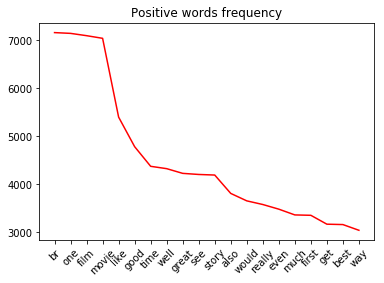

In [49]:
y_pos = [i[1] for i in pos_most_common]
y_neg = [i[1] for i in neg_most_common]
x = list(range(len(y_pos)))

w_pos = [i[0] for i in pos_most_common]
w_neg = [i[0] for i in neg_most_common]

plt.plot(x, y_pos, 'r-')
plt.xticks(x, w_pos, rotation='45')
plt.title('Positive words frequency')
plt.show()

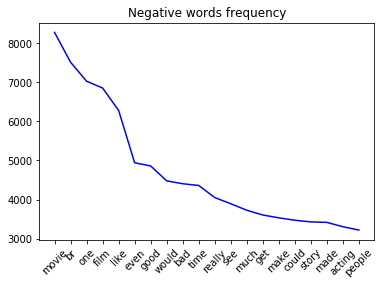

In [48]:
plt.plot(x, y_neg, 'b-')
plt.xticks(x, w_neg, rotation='45')
plt.title('Negative words frequency')
plt.show()

# Task 2
Prcess of computation is not added (models were run in separate notebooks)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

Transforming reviews into feature vectors 

In [ ]:
max_fatures = 2000
max_len = 250
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(reviewList)
X = tokenizer.texts_to_sequences(reviewList)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='pre')

In [ ]:
Y = np.zeros((len(labelList),2))
for i in range(len(labelList)):
    if labelList[i] == 'positive':
        Y[i][0] = 1
    elif labelList[i] == 'negative':
        Y[i][1] = 1

Building and training model with 4-fold train and test set. Evaluating the model

In [ ]:
conf_matrices = []

kf = KFold(n_splits=4, random_state=1, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    keras.backend.clear_session()
    model = None
    embed_dim = 100
    lstm_out = 196

    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    batch_size = 32
    
    model.fit(X_train, y_train, epochs = 7, batch_size=batch_size, verbose = 1)
    
    prediction  = model.predict(X_test)
    
    conf_matrices.append(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1)))

Methods to calculate F1

In [ ]:
def recall(conf):
    return conf[0,0]/(conf[0,0] + conf[1,0])


def precision(conf):
    return conf[0,0]/(conf[0,0] + conf[0,1])

def F1(conf):
    p = precision(conf)
    r = recall(conf)
    return 2 * p * r / (p + r)

# to score other class
def transform(conf):
    tp = conf[0,0]
    fp = conf[1,0]
    fn = conf[0,1]
    tn = conf[1,1]
    return np.array([[tn, fp],[fn, tp]])

In [ ]:
# positive F1
print(sum([F1(cm) for cm in conf_matrices])/4)
# negative F1
print(sum([F1(transform(cm)) for cm in conf_matrices])/4)

# Task 3

Reading and collecting pre-computed embeddings taken from https://nlp.stanford.edu/projects/glove/

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
vocab_size = len(tokenizer.word_index)+1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Training and evaluating a model with a fixed embedding

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

conf_matrices = []

kf = KFold(n_splits=4, random_state=1, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    embed_dim = 100
    lstm_out = 196

    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1], trainable=False))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    batch_size = 32
    
    model.fit(X_train, y_train, epochs = 7, batch_size=batch_size, verbose = 1)
    
    prediction  = model.predict(X_test)
    
    conf_matrices.append(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1)))

Calculating scores

In [ ]:
# positive F1
print(sum([F1(cm) for cm in conf_matrices])/4)
# negative F1
print(sum([F1(transform(cm)) for cm in conf_matrices])/4)